
# Project: Investigating appointments that were never fulfilled 

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

The primary goal of this project is to investigate a dataset consisting of about 100,000 medical appointments that were made by patients from the neighbourhoods of Brazil. Each patient's appointment (row) contain information regarding their `Gender`, `Age`, `ScheduledDay`, `AppointmentDay`, `Scholarship`, four diagnosed chronic illnesses and some other general information. 

Using this data, we analyse the relationship between the data elements and try to establish which characterics are indicative of whether or not a patient will actually show up for an appointment that they had made.

The *dependent variable* in our analysis is the condition of showing up or not showing up to an appointment, represented by `No` or `Yes` respectively in the `No_show` column of our data 

That is, we ask the following questions: 
###### What personal factors are linked to actually showing up for an appointment?
###### What external factors are linked to fulfillment of appointments?


Personal factors being Gender, Age, Scholarship,health conditions such as Hypertension, Diabetes, Alcoholism and Handicap.

External factors referring to whether or not the patient recieved an SMS on making the appointment or the difference (in days) between the day of scheduling and the date of appointment. 





In [1]:
# Import statements for all of the packages that are used

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline 

<a id='wrangling'></a>
## Data Wrangling

Since the data is stored in a `.csv` file, let's load it into a DataFrame for further analysis. 

An overview of the data reveals that it is structured as follows:

### General Properties

In [2]:
df = pd.read_csv('noshowappointments.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB



### Data Cleaning

For convinience, I've converted all the column names to lower case only and fixed some typos:

In [3]:
df.columns = map(str.lower, df.columns)
df.rename(columns = {'hipertension':'hypertension','handcap' : 'handicap'}, inplace = True)
df.head()

,patientid,appointmentid,gender,scheduledday,appointmentday,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


#### Space, Time and Strings!
Although the data doesn't have any values missing from its rows, we notice some problems right off the bat.
Firstly, the `Scheduleddate` and `Appointmentdate` columns are of *object* data type  (i.e, Strings) and aren't very helpful as is. They're more useful to us as *datetime* and we can make the conversion as follows:



In [93]:
df['scheduledday'] = pd.to_datetime(df.scheduledday.apply(lambda x: x[:10]))
df['appointmentday'] =  pd.to_datetime(df.appointmentday)

Since time travel hasn't been invented yet, let's also drop any rows where appointments were made for dates BEFORE the date of scheduling. 



In [94]:
df = df.query('appointmentday >= scheduledday')

#### Drop it like it's hot.
With that out of the way, we can now proceed to drop those columns that we do not have any need for in our analysis:
`PatientID` and `AppointmentID` are unique to for each patient and appointment respectively and aren't very useful. Although the `Neighbourhod` in which the hospital is located may have some correlation with the frequency of missed appointments, we are not going to focus on that in this analysis. 


In [95]:
#Dropping columns that we do not need

df.drop(columns = ['patientid', 'appointmentid', 'neighbourhood'], inplace = True)

It appears that the `no-show` column has entries in terms of `Yes` and `No`. Converting these to `True` and `False` respectively, enables us to perform aggregations of that column since python True and False values as 1's and 0's. We make this conversion as follows:


In [96]:
df.replace({'no-show': {'Yes': True, 'No': False}}, inplace=True)
df.head()

,gender,scheduledday,appointmentday,age,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no-show
0,F,2016-04-29,2016-04-29,62,0,1,0,0,0,0,False
1,M,2016-04-29,2016-04-29,56,0,0,0,0,0,0,False
2,F,2016-04-29,2016-04-29,62,0,0,0,0,0,0,False
3,F,2016-04-29,2016-04-29,8,0,0,0,0,0,0,False
4,F,2016-04-29,2016-04-29,56,0,1,1,0,0,0,False


Let's check the data one more time to make sure everything is as expected.

In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110522 entries, 0 to 110526
Data columns (total 11 columns):
gender            110522 non-null object
scheduledday      110522 non-null datetime64[ns]
appointmentday    110522 non-null datetime64[ns]
age               110522 non-null int64
scholarship       110522 non-null int64
hypertension      110522 non-null int64
diabetes          110522 non-null int64
alcoholism        110522 non-null int64
handicap          110522 non-null int64
sms_received      110522 non-null int64
no-show           110522 non-null bool
dtypes: bool(1), datetime64[ns](2), int64(7), object(1)
memory usage: 9.4+ MB


Let's now use the pandas describe() function to check for any possible improvements

In [98]:
df.describe()

,age,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received
count,110522.000000,110522.000000,110522.000000,110522.000000,110522.000000,110522.000000,110522.000000
mean,37.089041,0.098270,0.197255,0.071868,0.030401,0.022231,0.321040
std,23.110064,0.297681,0.397928,0.258270,0.171689,0.161493,0.466878
min,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


It seems that there are some patients with 'negative' ages. We know that this isnt possible, although it could be reffering to something else. But for our analysis, we'll only check for patients aged 0 (new-borns) and up. 

In [99]:
#Eliminate negative ages

df = df.query('age >= 0')

Looks like we're good to go for now!

<a id='eda'></a>
## Exploratory Data Analysis

Now that we have data that's pretty neat and clean, lets get started with the analysis, and proceed to answer the questions that were asked in the Introduction part. Before we go on, let's create masks for the two conditions that we will be using most often to filter the dataset by: show and noshow


In [100]:
showed = df['no-show'] == False  #used to return the subet of data consisting of fulfilled appointments
noshow = df['no-show'] == True  #used to return the subet of data consisting of no-show appointments

### Does gender have any correlation with show/no show ?
Does being male or female make a person any more likely to not show up for an appointment? Let's see what the data tells us. 

First, let's check the total number of males and females in the dataset. 

In [101]:
gender_counts = df.gender.value_counts()
gender_counts

F    71836
M    38685
Name: gender, dtype: int64

Looks like there are significantly more Females than Males in this dataset. 

So to work around this, let us check the *proportion of women* and the *proportion of men* that **DO NOT** show up for appointments  

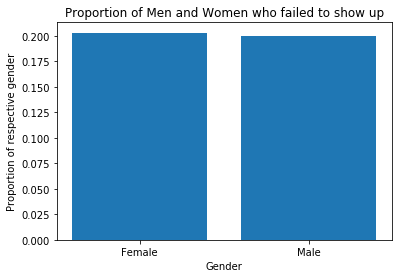

In [102]:
plt.bar(['Female', 'Male'],(df[noshow].gender.value_counts()/gender_counts).values)
plt.ylabel('Proportion of respective gender')
plt.xlabel('Gender')
plt.title("Proportion of Men and Women who failed to show up")
plt.legend;

This tells us that approximately **20% of all men** and **20% of all women** failed to show up for the appointments they had made. 

Which means that the gender probably does not play a significant role in this regard.

### What about age? 

Do older people tend to miss fulfill appointments more? Do younger people? 

Let's see.

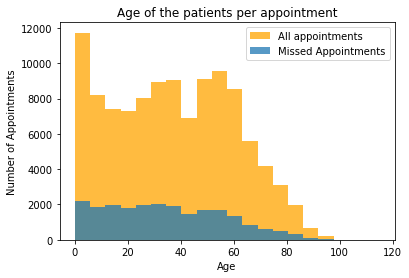

In [103]:
plt.hist(df.age, alpha=0.75,bins = 20, color='orange', label='All appointments')
plt.hist(df[noshow].age,bins = 20, alpha=0.75, label='Missed Appointments')
plt.xlabel("Age")
plt.ylabel("Number of Appointments")
plt.title("Age of the patients per appointment")
plt.legend();

From the above histogram, although it might *seem* that younger people miss their appointments *slightly* more often than older people, what with the distribution being slightly skewed to the right, We must take into the consideration the fact that the ages of **ALL** appointments is also skewed to the right. Because of this, we can say that in the dataset under analysis, more young patients have missed their appointments than the older ones, but we cannot say that younger people *tend* to miss their appointments more than older people. 


### Do people with medical conditions tend to keep their appointments more?

I had mentioned in the beginning that the dataset consists of information regarding whether or not patients have been diagnosed with any of 4 medical conditions: Handicap, Alcoholism, Hypertension and Diabetes. Let us see if patients suffering from these conditions tend to keep their appointments more, in the same way as we had 

#### Handicap


In [104]:
df.handicap.value_counts()

0    108282
1      2040
2       183
3        13
4         3
Name: handicap, dtype: int64

It seems like Handicap has 5 different values: 0,1,2,3,4, With 0 representing NO handicap. Since the number of occurences of 2,3 and 4 are so small, let's generalise the handicap category to just 0 and 1, representing the absence and presence of some handicap respectively

In [105]:
df.replace({'handicap': {2: 1, 3: 1, 4: 1}}, inplace=True)
df.handicap.value_counts()

0    108282
1      2239
Name: handicap, dtype: int64

With that taken care of, let's proceed to check the proportion of people who missed ther appointments with respect to handicap


In [136]:
handicap = df[noshow].handicap.value_counts()/df.handicap.value_counts()
handicap

0    0.202333
1    0.180884
Name: handicap, dtype: float64

Looks like about 20% of non-handicapped and 18% of all handicapped people have missed their appointment.

Not a big difference. But let's go ahead and check the rest. 


#### Alcoholism?

In [133]:
alcoholism = df[noshow].alcoholism.value_counts()/df.alcoholism.value_counts()
alcoholism

0    0.201911
1    0.201488
Name: alcoholism, dtype: float64

#### Hypertension 

In [134]:
hypertension = df[noshow].hypertension.value_counts()/df.hypertension.value_counts()
hypertension

0    0.208995
1    0.173020
Name: hypertension, dtype: float64

#### Diabetes

In [135]:
diabetes = df[noshow].diabetes.value_counts()/df.diabetes.value_counts()
diabetes

0    0.203591
1    0.180033
Name: diabetes, dtype: float64

It appears that apart from alcoholism, patients diagnosed with the other 3 conditions tended to miss their appointments less  than those without. 

Let's visualise this:

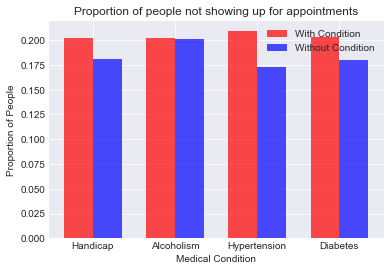

In [158]:
sns.set_style('darkgrid')
ind = np.arange(4)  # the x locations for the groups
width = 0.35

x1 = [handicap[0], alcoholism[0], hypertension[0], diabetes[0]]
x2 = [handicap[1], alcoholism[1], hypertension[1], diabetes[1]]

with_prob = plt.bar(ind, x1, width, color='red', alpha=.7, label='With Condition ')
without_prob = plt.bar(ind + width, x2 , width, color='blue', alpha=.7, label='Without Condition')

# title and labels

plt.xlabel('Medical Condition')
plt.ylabel('Proportion of People')
plt.title('Proportion of people not showing up for appointments')
locations = ind + width / 2  # xtick locations
labels = ['Handicap', 'Alcoholism', 'Hypertension', 'Diabetes']  # xtick labels
plt.xticks(locations, labels)
plt.legend();

This begs the question: Would people with more health problems tend to keep their appointments more?

Let's find out! 

In [110]:
#Find the total number of people with more than one ailment

problems_count = (df.handicap+df.diabetes+df.hypertension).value_counts()
problems_count


0    86033
1    17351
2     6779
3      358
dtype: int64

The above output shows us the total number of people with 0 or more health problems

In [113]:
#Find the number of people with more than one ailment that didnt show up for their appointments

no = df[noshow]  # assign no show subset to DataFrame 'no' for convinience
problems_noshow = (no.handicap+no.diabetes+no.hypertension).value_counts()
problems_noshow


0    18016
1     3044
2     1199
3       55
dtype: int64

In [114]:
#Proportion of people with respective number of problems not showing up

p_proportions = problems_noshow/problems_count
p_proportions

0    0.209408
1    0.175437
2    0.176870
3    0.153631
dtype: float64

While obviously this doesnt present conclusive evidence, it does seem that people diagnosed with 3 problems missed appointments less than those with  1 or 2 problems who in turn missed their appointments less than those with no problems.

Let's try and visualise this

Text(0.5,1,'Number of ailments vs missed appointments')

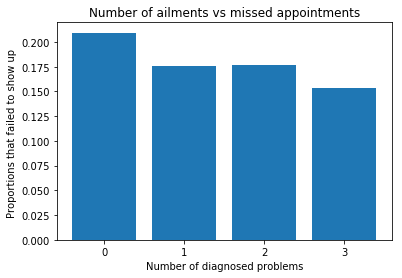

In [126]:
plt.bar(['0','1','2','3'], height = p_proportions.values)
plt.xlabel('Number of diagnosed problems')
plt.ylabel('Proportions that failed to show up ')
plt.title("Number of ailments vs missed appointments")

### Time to appointment

Do appointments that were made for days much later from the days on which they were scheduled, tend to be more prone to no-shows?  

For example: Is an appointment made for a date 10 days later more likely to be fulfilled than say, an appointment made for a date 45 days later? Only one way to find out!


This is the point where I explain the purpose of having converted those pesky strings into *datetime* objects: 

Thanks to that conversion, we're now able to subtract the two columns and obtain the difference in number of days between date of appointment and date of scheduling! 

Let's do that and assign that difference to a new column: `wait_period`


In [116]:
#First eliminate any rows containing apoointments made for day BEFORE the day of scheduling

#Now we can calculate difference in dates
df['wait_period'] = df.appointmentday - df.scheduledday

#Convert it into an interger data type, since we just want the number of days 
df.wait_period = df.wait_period.map(str).apply(lambda x: x.split(" ")[0]).map(int)



Looks like appointments were made for dates that were upto 179 days away for a few, starting from same-day appointments.

Let's check  how the average wait period of those appointments that were not fulfilled compares to those that were.

In [117]:
df.wait_period.describe()

count    110521.000000
mean         10.184345
std          15.255153
min           0.000000
25%           0.000000
50%           4.000000
75%          15.000000
max         179.000000
Name: wait_period, dtype: float64

In [118]:
df[showed].wait_period.mean()

8.754758692620767

In [119]:
df[noshow].wait_period.mean()

15.835484449224701

Interesting! It seems that *on an average* , the people who missed their appointments had made an appointment 15.6 days away, while those who showed up to their appointments, made appointments 8.75 days away. 

This information could be evidence that it's probably better not to make appointments too early if we wish to fulfill it.

### SMS sent to patients

Lastly, let's check to see if patients were more likely to fulfill their appointment if they received an sms regarding the appointment. This again can be checked similar to our previous conditions:

In [120]:
df[noshow].sms_received.value_counts()/df.sms_received.value_counts()

0    0.166980
1    0.275745
Name: sms_received, dtype: float64

You'd think that people would be able to keep track of their appointments easily and tend to show up for them more often if they'd received and SMS but from our analysis of this dataset, it turns out to be quite the opposite! 

About 27.5% of all people who received an SMS regarding their appointment, didn't show up 

While only about 16.5% of people who didn't receive any SMS failed to show up. 

<a id='conclusions'></a>
## Conclusions

From our analysis, we managed to notice some possible trends in the data:

For example,
Men and Women both tend to show similar trends in keeping up with appointments. 
People with a larger number of diagnosed medical conditions may tend to keep their appointments more often.
People who recieved an SMS may be more likely to not show up for that appointement for those who don't receive any SMS. 
Younger patients may tend to skip their appointments more often. Making an appointment too early may be linked to an increased likelyhood of not showing up for the appointments.

In conclusion, it must be stated that any observations of correlations made during the analysis are **TENTATIVE** and are not to be considered to be causations. 

Further studies involving statistical tests and machine learning could lead to more precise and accurate results. 

